<a href="https://colab.research.google.com/github/spooozy/Systems-analysis-machine-modeling/blob/main/SA%26MM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, kstwo
import mpmath as mp
import math

In [3]:
class Lemmer():
    def __init__(self, seed=1, a=16807, c=78125, m=2147483647):
        self.state = seed
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state / self.m

    def generate(self, n):
        return np.array([self.next() for _ in range(n)])

In [4]:
N = 10000
BINS = 30

generator = Lemmer(seed=4200)
numbers = generator.generate(N)

**Plotting a histogram**

In [5]:
def plot_histogram(sample, bins=30, title="Histogram", color="#C5ABDE",
                   density=True, theoretical_density=None, xlim=(0, 1)):
    plt.figure(figsize=(10, 6))

    n, bins, patches = plt.hist(sample, bins=bins, density=density,
                               alpha=0.7, color=color, edgecolor='black',
                               linewidth=0.5, label='Empirical Density')

    if theoretical_density is not None:
        x = np.linspace(xlim[0], xlim[1], 1000)
        y = theoretical_density(x)
        plt.plot(x, y, 'r-', linewidth=2, label='Theoretical Density')

    plt.xlabel('Value')
    plt.ylabel('Density' if density else 'Frequency')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(xlim)

    plt.tight_layout()
    plt.show()

    return n, bins


In [6]:
def uniform_density(x, a=0, b=1):
    return np.where((x >= a) & (x <= b), 1/(b-a), 0)

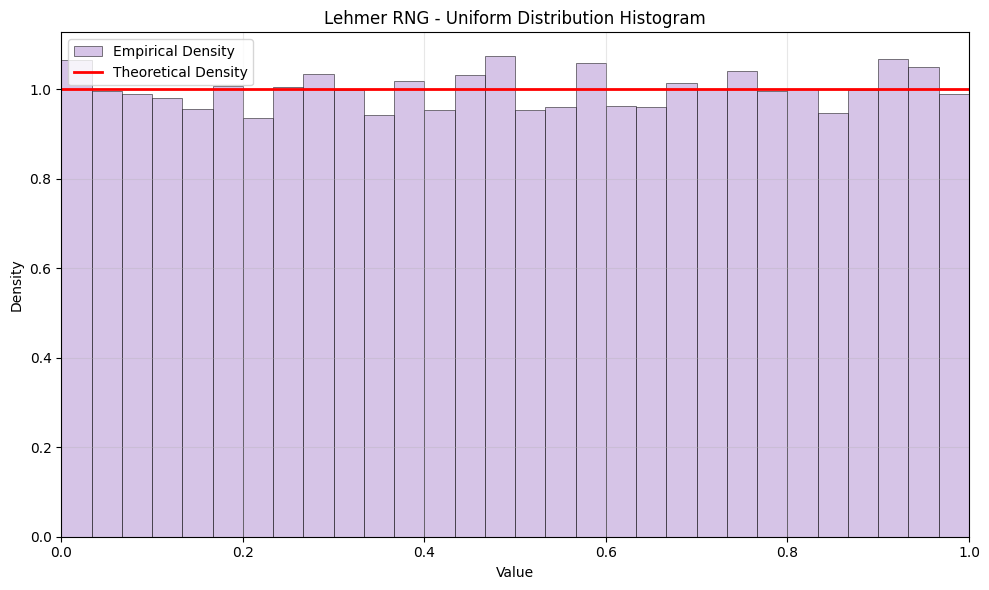

In [31]:
frequencies, bin_edges = plot_histogram(
    sample=numbers,
    bins=BINS,
    title="Lehmer RNG - Uniform Distribution Histogram",
    color="#C5ABDE",
    theoretical_density=lambda x: uniform_density(x, 0, 1)
)

### **χ2**

In [8]:
def theoretical_cdf(x, distribution="uniform", params=None):
    if x < 0:
      return 0.0
    elif x > 1:
      return 1.0
    else:
      return x

In [22]:
def X2_test (numbers, k=30, distribution="uniform", params=None, alpha=0.05):
  n = len(numbers)
  bins = np.linspace(0, 1, k + 1)
  observed_counts, _ = np.histogram(numbers, bins=bins)
  expected_counts = np.zeros(k)
  for i in range(k):
    F_right = theoretical_cdf(bins[i + 1], distribution, params)
    F_left = theoretical_cdf(bins[i], distribution, params)
    expected_counts[i] = n * (F_right - F_left)
  X2_stat = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
  df = k - 1
  p_value = chi2.sf(X2_stat, df)
  critical_value = chi2.ppf(1 - alpha, df)
  reject_null = X2_stat > critical_value
  results = {
        'chi2_statistic': X2_stat,
        'degrees_of_freedom': df,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_null': reject_null,
        'observed_counts': observed_counts,
        'expected_counts': expected_counts,
        'bins': bins,
        'alpha': alpha
    }

  return results

In [23]:
def plot_X2_results(sample, chi2_results, name="", distribution="uniform", params=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  k = len(chi2_results['observed_counts'])
  bins = chi2_results['bins']
  observed = chi2_results['observed_counts']
  expected = chi2_results['expected_counts']

  print(f"V = {chi2_results['chi2_statistic']:.4f}")
  print(f"P-value = {chi2_results['p_value']:.4f}")

  n, _, patches = ax1.hist(sample, bins=bins, density=True, alpha=0.7,
                            color='#C5ABDE', edgecolor='black', label='Empirical Density')
  for i, patch in enumerate(patches):
    deviation = abs(observed[i] - expected[i]) / np.sqrt(expected[i])
    if deviation > 2:
      patch.set_facecolor('#FAD18F')
      patch.set_alpha(0.8)

  x_theo = np.linspace(0, 1, 1000)
  y_theo = np.ones_like(x_theo)

  ax1.plot(x_theo, y_theo, 'g-', linewidth=2, label='Theoretical density')
  ax1.set_xlabel('Value')
  ax1.set_ylabel('Probability Density')
  ax1.set_title(f'{name} - Distribution histogram')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  x_pos = np.arange(k)
  width = 0.35

  ax2.bar(x_pos - width/2, observed, width, label='Empirical Density', alpha=0.7, color='#C5ABDE')
  ax2.bar(x_pos + width/2, expected, width, label='Theoretical Density', alpha=0.7, color='#FAD18F')
  ax2.set_xlabel('Intervals')
  ax2.set_ylabel('Frequency')
  ax2.set_title(f'{name} - Comparison of observed and expected frequencies')
  ax2.legend()
  ax2.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

In [11]:
def run_chi_square_analysis(rng, name, distribution="uniform", params=None, sample_sizes=[10000, 300], k=20, alpha=0.05):
    for i, n in enumerate(sample_sizes):
      sample = rng.generate(n)
      X2_results = X2_test(sample, k=k, distribution=distribution, params=params, alpha=alpha)
      plot_X2_results(sample, X2_results, f"{name} (n={n})", distribution, params)

V = 28.4960
P-value = 0.4915


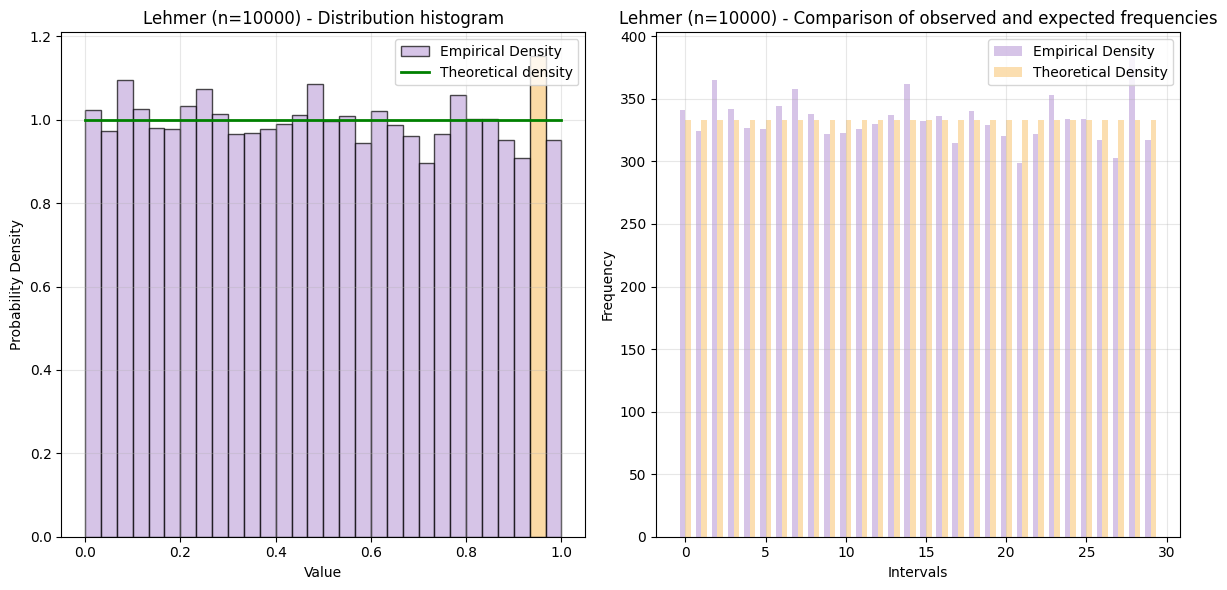

V = 28.7420
P-value = 0.4786


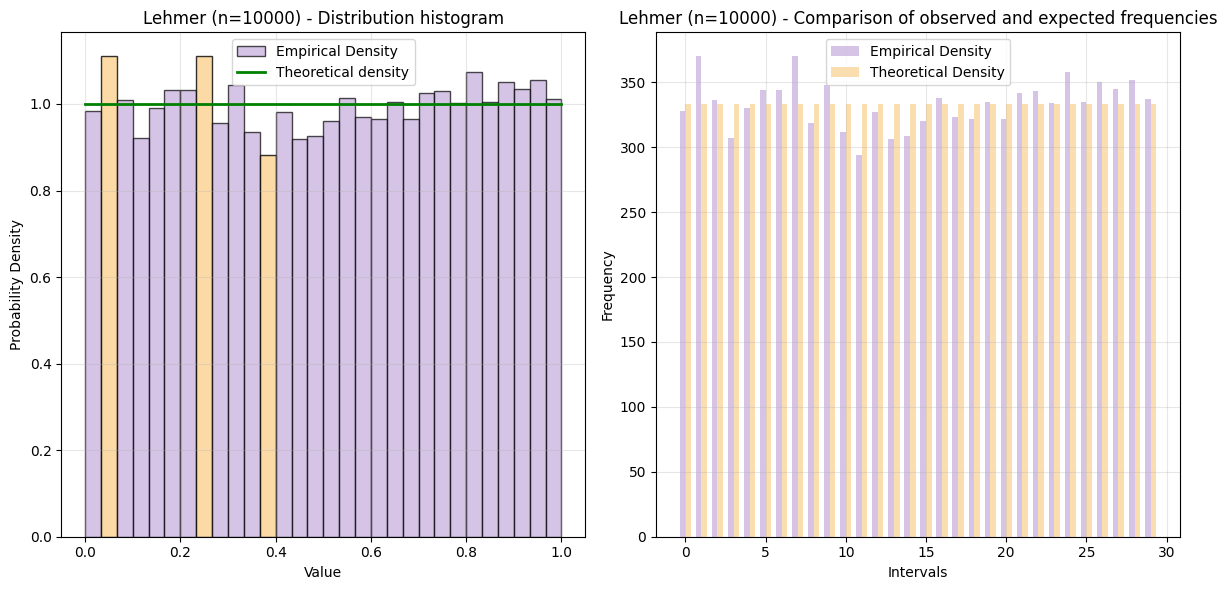

V = 32.3540
P-value = 0.3046


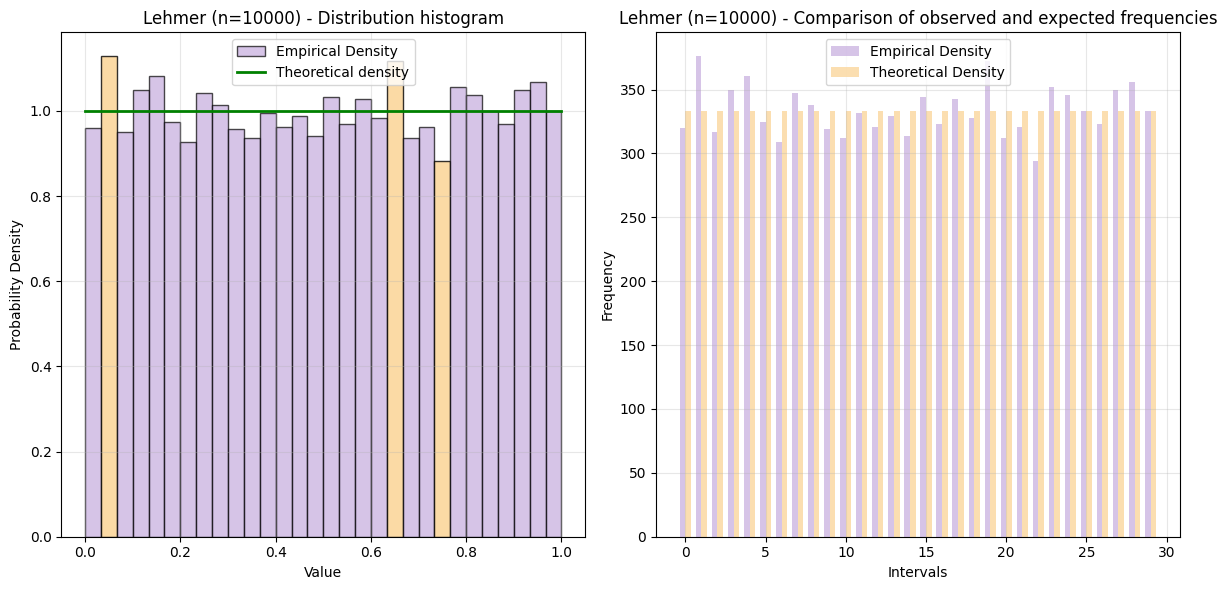

In [24]:
run_chi_square_analysis(generator, "Lehmer",distribution="uniform", params=None, sample_sizes=[10000, 10000, 10000], k=BINS)

V = 24.6000
P-value = 0.6988


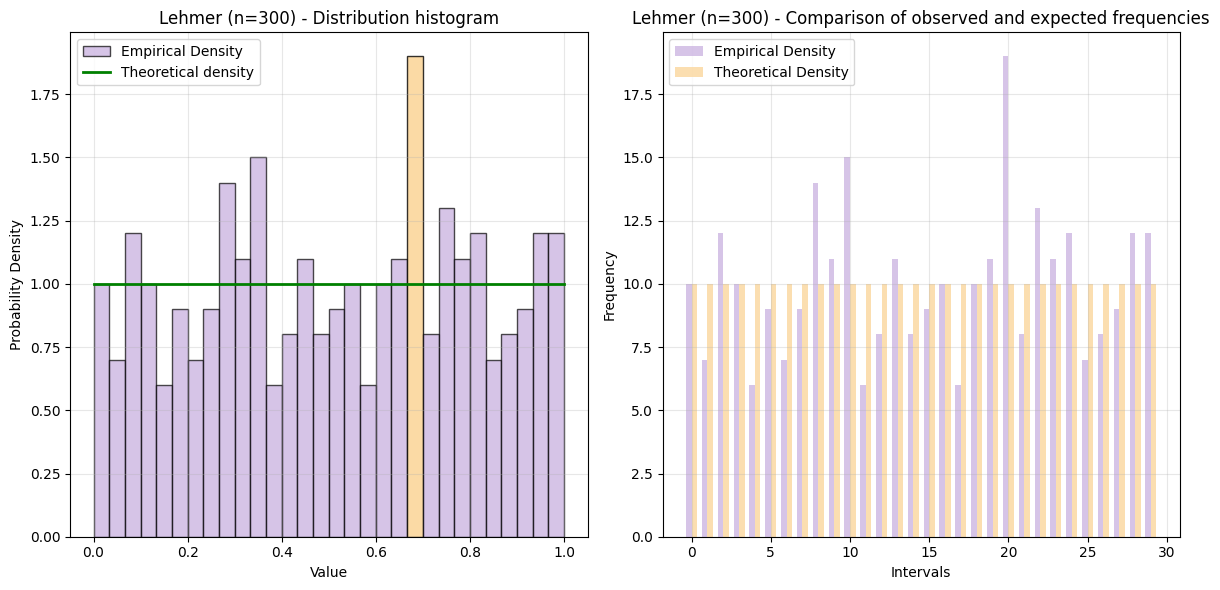

In [40]:
run_chi_square_analysis(generator, "Lehmer",distribution="uniform", params=None, sample_sizes=[300], k=BINS)

 ### **Kolmogorov–Smirnov criterion (KS criterion)**

In [14]:
def theoretical_cdf_point(x, distribution="uniform", params=None):
  return max(0, min(1, x))

In [15]:
def ks_test(sample, distribution="uniform", params=None, alpha=0.05):
    n = len(sample)
    sample_sorted = np.sort(sample)

    empirical_cdf = np.arange(1, n + 1) / n

    theoretical_cdf = np.array([theoretical_cdf_point(x, distribution, params) for x in sample_sorted])

    D_plus_vals = empirical_cdf - theoretical_cdf
    D_minus_vals = theoretical_cdf - (np.arange(0, n) / n)

    D_plus = np.max(D_plus_vals)
    D_minus = np.max(D_minus_vals)
    D_stat = max(D_plus, D_minus)

    K_plus = math.sqrt(n) * D_plus
    K_minus = math.sqrt(n) * D_minus
    K_stat = max(K_plus, K_minus)

    p_value = kstwo.sf(D_stat, n)

    critical_value = kstwo.ppf(1 - alpha, n)

    reject_null = D_stat > critical_value

    max_D_plus_idx = np.argmax(D_plus_vals)
    max_D_minus_idx = np.argmax(D_minus_vals)

    results = {
        'D_plus': D_plus,
        'D_minus': D_minus,
        'D_stat': D_stat,
        'K_plus': K_plus,
        'K_minus': K_minus,
        'K_stat': K_stat,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_null': reject_null,
        'sample_sorted': sample_sorted,
        'empirical_cdf': empirical_cdf,
        'theoretical_cdf': theoretical_cdf,
        'D_plus_vals': D_plus_vals,
        'D_minus_vals': D_minus_vals,
        'max_D_plus_idx': max_D_plus_idx,
        'max_D_minus_idx': max_D_minus_idx,
        'sample_size': n,
        'alpha': alpha
    }

    return results

In [35]:
def plot_ks_results(sample, ks_results, name="", distribution="uniform", params=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    print(f"K⁺ = {ks_results['K_plus']:.6f}")
    print(f"K⁻ = {ks_results['K_minus']:.6f}")
    print(f"P-value = {ks_results['p_value']:.6f}")
    print(f"D = {ks_results['p_value']:.6f}")

    p = ks_results['p_value']
    if p < 0.01:
        interval = "[0, 0.01)"
    elif p < 0.05:
        interval = "[0.01, 0.05)"
    elif p < 0.1:
        interval = "[0.05, 0.1)"
    else:
        interval = "[0.1, 1.0]"

    print(f"P-value is in interval: {interval}")

    sample_sorted = ks_results['sample_sorted']
    empirical_cdf = ks_results['empirical_cdf']
    theoretical_cdf = ks_results['theoretical_cdf']
    D_plus_vals = ks_results['D_plus_vals']
    D_minus_vals = ks_results['D_minus_vals']

    n, bins, patches = ax1.hist(sample, bins=30, density=True, alpha=0.7,
                               color='#C5ABDE', edgecolor='black',
                               label='Empirical Density')


    x_theo = np.linspace(0, 1, 1000)
    y_theo = np.ones(1000)

    ax1.plot(x_theo, y_theo, 'r-', linewidth=2, label='Theoretical Density')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Probability Density')
    ax1.set_title(f'{name} - Distribution histogram')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.step(sample_sorted, empirical_cdf, where='post', label='Empirical CDF', color='blue', linewidth=2)
    ax2.plot(sample_sorted, theoretical_cdf, label='Theoretical CDF', color='red', linestyle='--', linewidth=2)

    max_D_plus_idx = ks_results['max_D_plus_idx']
    max_D_minus_idx = ks_results['max_D_minus_idx']

    ax2.axvline(x=sample_sorted[max_D_plus_idx], color='green', linestyle='-', alpha=0.7, linewidth=2, label=f'D+ max (x={sample_sorted[max_D_plus_idx]:.3f})')
    ax2.axvline(x=sample_sorted[max_D_minus_idx], color='orange', linestyle='-', alpha=0.7, linewidth=2, label=f'D- min (x={sample_sorted[max_D_minus_idx]:.3f})')

    ax2.fill_between(sample_sorted, empirical_cdf, theoretical_cdf, where=(empirical_cdf >= theoretical_cdf), color='green', alpha=0.2, label='D+')
    ax2.fill_between(sample_sorted, theoretical_cdf, empirical_cdf, where=(theoretical_cdf >= empirical_cdf),color='orange', alpha=0.2, label='D-')

    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{name} - Comparison of Theoretical and Empirical CDF')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [16]:
def run_ks_analysis(rng, name, distribution="uniform", params=None, sample_sizes=[10000, 10000, 10000], alpha=0.05):
    for i, n in enumerate(sample_sizes):
        sample = rng.generate(n)

        ks_results = ks_test(
            sample, distribution=distribution, params=params, alpha=alpha
        )
        plot_ks_results(sample, ks_results, f"{name} (n={n})",
                       distribution, params)

K⁺ = 0.853665
K⁻ = 0.578530
P-value = 0.457263
D = 0.457263
P-value is in interval: [0.1, 1.0]


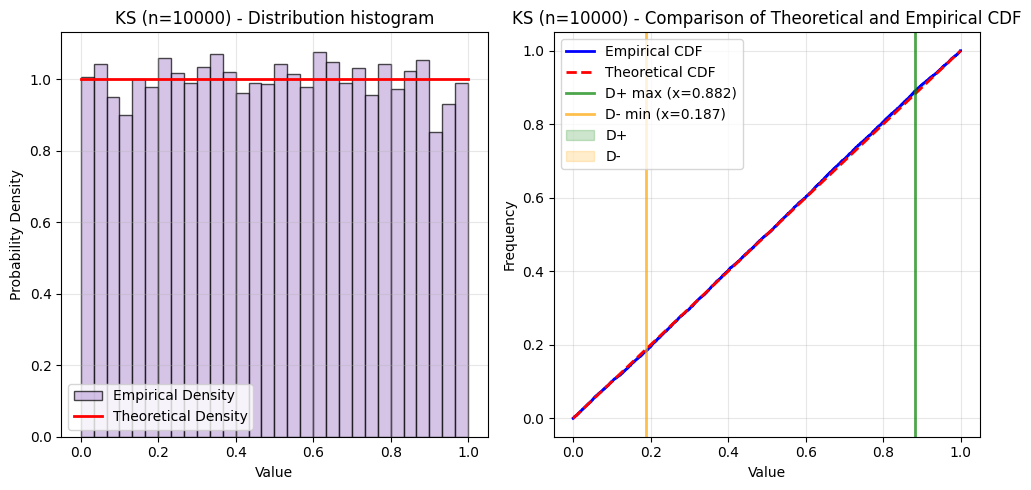

K⁺ = 0.684788
K⁻ = 0.371300
P-value = 0.733665
D = 0.733665
P-value is in interval: [0.1, 1.0]


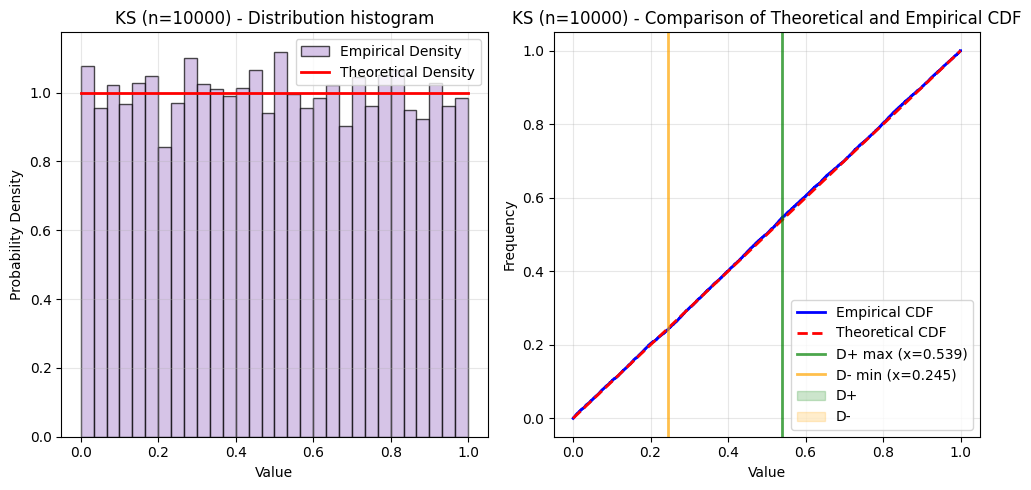

K⁺ = 0.462868
K⁻ = 0.967426
P-value = 0.304616
D = 0.304616
P-value is in interval: [0.1, 1.0]


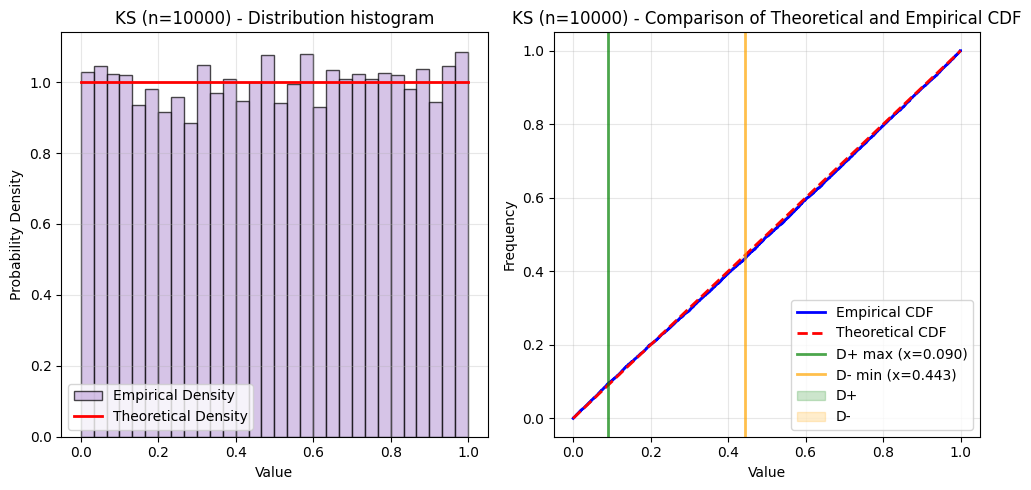

In [36]:
run_ks_analysis(generator, "KS", distribution="uniform", params=None, sample_sizes=[10000, 10000, 10000])

K⁺ = 0.373777
K⁻ = 1.014632
P-value = 0.186707
D = 0.186707
P-value is in interval: [0.1, 1.0]


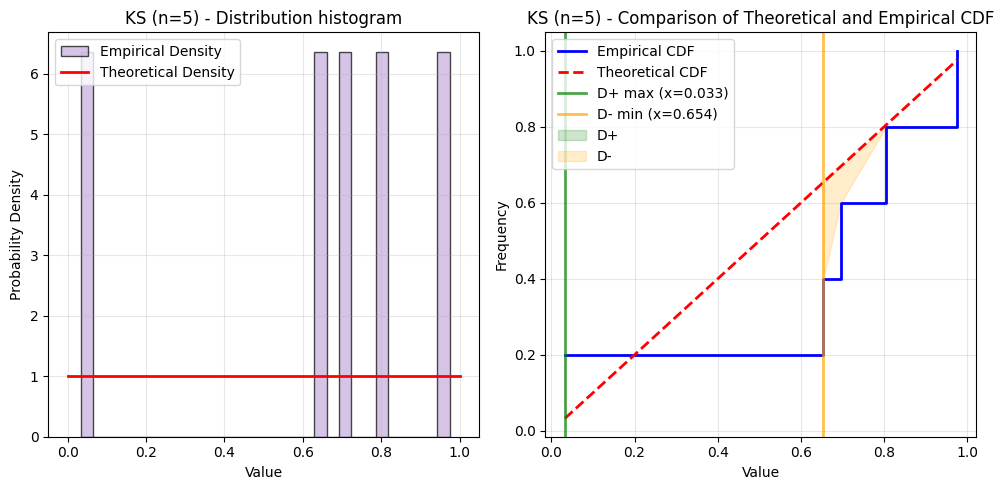

In [46]:
run_ks_analysis(generator, "KS", distribution="uniform", params=None, sample_sizes=[5])